In [1]:
# Imports and constants

import qiskit, random, matplotlib, time

numBits= 6 # Maximum key length
numCompare= 6 # Number of sifted key bits to share (and then discard)


def getRandomBases(numBits):
    b= []
    for i in range(numBits):
        if random.random() > 0.5: b.append("x")
        else: b.append("+")
    return b


simulator= qiskit.Aer.get_backend('qasm_simulator')
def sim(circ):
    job= qiskit.execute(circ, simulator, shots=1)
    
    result= job.result().get_counts(circ)
    
    key= list(result.keys())[0]
    key= "".join(list(reversed(key)))
    
    return key

def applyBases(circ, bases):
    circ.barrier()
    for i,bse in enumerate(bases):
        if bse=="x": circ.h(i)
    return circ

# Case 1: No eavesdropper

Alice's initial key:		 010100
Alice's measurement bases:	 x+xxxx


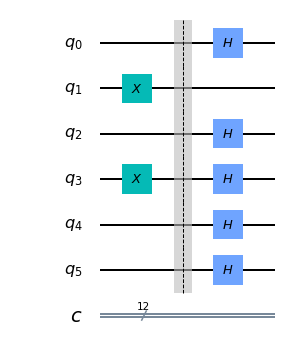

In [2]:
# -----------------------
# Alice's Keys + bases
# -----------------------

# Generate Alice's key
keyA= random.randint(0, 2**numBits)
keyA= str(bin(keyA))[2:].zfill(numBits) # ignore Python's '0b' prefix for binary literals and zeropad
print("Alice's initial key:\t\t", keyA)


# Alice's measurement bases
basesA= getRandomBases(numBits)
print("Alice's measurement bases:\t", "".join(basesA))



# -----------------------
# Quantum representation
# -----------------------

circA= qiskit.QuantumCircuit(numBits, numBits*2) # (One classical reg for Bob, one for Eve)

# Initialize qubits (|0> by default)
for i,bit in enumerate(keyA):
    if bit=="1": circA.x(i) # apply not-gate

circA.barrier() # aesthetic purposes
        
    
# Apply bases (assume rectilinear + as default)
for i,bse in enumerate(basesA):
    if bse=="x": circA.h(i) # hadamard thingy

circA.draw(output='mpl') # show circuit

Bob's measurement bases:	 +x+xx+


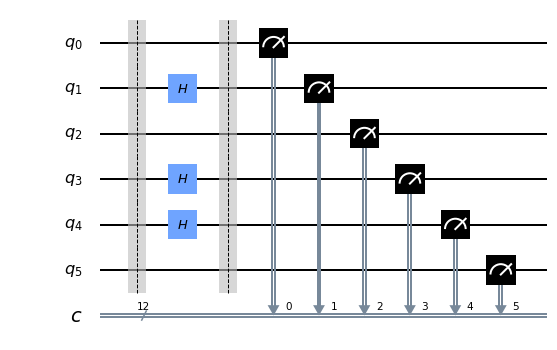

In [3]:
# -----------------------
# Bob's bases
# -----------------------

basesB= []
basesB= getRandomBases(numBits)
print("Bob's measurement bases:\t", "".join(basesB))



# -----------------------
# Quantum representation
# -----------------------

circB= qiskit.QuantumCircuit(numBits, numBits*2)        
circB.barrier()

# Apply bases (assume rectilinear + as default)
for i,bse in enumerate(basesB):
    if bse=="x": circB.h(i) # hadamard thingy

# Measurement probes
circB.barrier()
circB.measure(range(numBits), range(numBits))
circB.draw(output='mpl')
        
circB.draw(output='mpl') # show circuit

In [4]:
# Alice sends Bob the key (in qubits!)
circC= circA + circB

# Final circuit
circC.draw(output='mpl')

# Bob gets results
keyB= sim(circC)[:numBits]

In [5]:
# -----------------------
# Comparing the bases
# -----------------------

matches= [i for i in range(len(basesA)) if basesA[i] == basesB[i]]
siftA= [keyA[i] for i in matches]
siftB= [keyB[i] for i in matches]

n= min(len(siftA),numCompare)
detectProb= 1 - 0.75**n

# -----------------------
# Summary
# -----------------------

print("Alice's key:\t\t", str(keyA))
print("Bob's measured key:\t", keyB)

print()
print("Alice tells Bob her bases:", "".join(basesA))
print("Bob tells Alice his bases:", "".join(basesB))

print()
print("Bases match at indices:", matches)
print("\n----------\n\nAlice and Bob now ignore bits where measurement basis differ.")

print()
print("Alice's sifted key:\t", "".join(siftA))
print("Bob's sifted key:\t", "".join(siftB))

print(f"\n----------\n\nAlice and Bob now share the first {n} bits of their keys.")
print("Alice shares:\t", "".join(siftA[:n]))
print("Bob shares:\t", "".join(siftB[:n]))

print("\n----------\n")
if siftA[:n] != siftB[:n]: print("***Alice's and Bob's shared keys don't match! There's an evesdropper!***")
else: print(f"***Alice and Bob are {int(detectProb*100)}% sure there's no eavesdropper!***")

Alice's key:		 010100
Bob's measured key:	 010100

Alice tells Bob her bases: x+xxxx
Bob tells Alice his bases: +x+xx+

Bases match at indices: [3, 4]

----------

Alice and Bob now ignore bits where measurement basis differ.

Alice's sifted key:	 10
Bob's sifted key:	 10

----------

Alice and Bob now share the first 2 bits of their keys.
Alice shares:	 10
Bob shares:	 10

----------

***Alice and Bob are 43% sure there's no eavesdropper!***


# Case 2: Eavesdropper

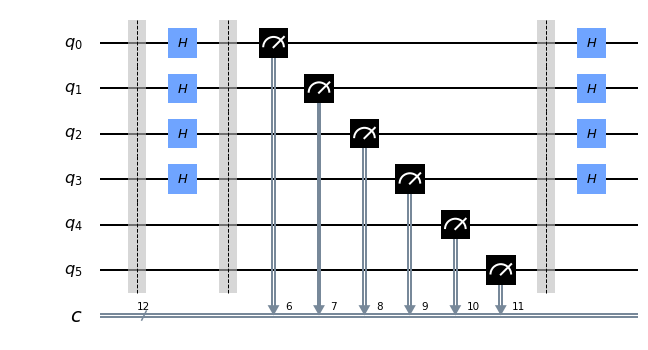

In [6]:
# -----------------------
# Reuse intial key and chosen bases
# -----------------------
keyA= keyA
basesA= basesA
basesB= basesB

circA= circA
circB= circB


# -----------------------
# Introduce Eve
# -----------------------
circE= qiskit.QuantumCircuit(numBits, numBits*2)
basesE= getRandomBases(numBits) # random measurement bases

circE.barrier()
for i,bse in enumerate(basesE): # apply Eve's bases
    if bse=="x": circE.h(i)

circE.barrier()
circE.measure(range(numBits), range(numBits,numBits*2)) # measurement probes  

circE.barrier()
for i,bse in enumerate(basesE): # Change state if Eve guesses wrong and fix state if right
    if bse=="x": circE.h(i)

circE.draw(output='mpl')

000101000101 000101 000101


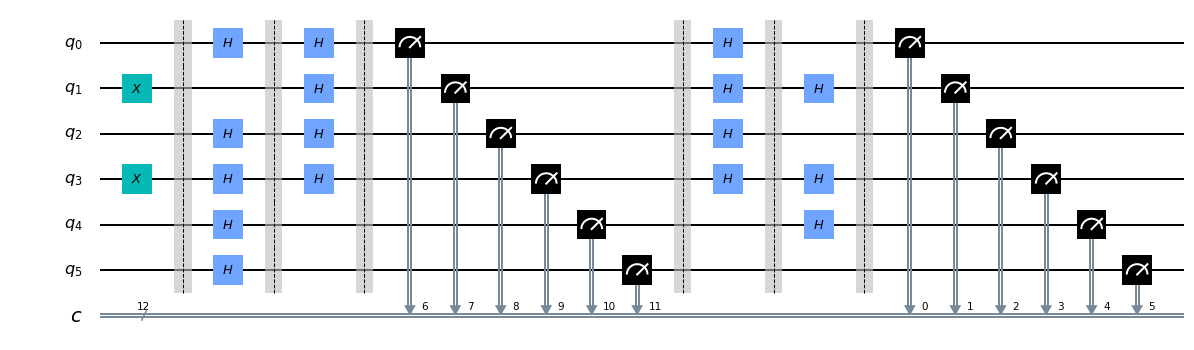

In [7]:
# -----------------------
# Alice --> (Eve) --> Bob
# -----------------------

circC= circA + circE + circB

k= sim(circC)
keyB= k[numBits:]
keyE= k[:numBits]

print(k,keyB,keyE)

# Final circuit
circC.draw(output='mpl')

In [8]:
# -----------------------
# Comparing the bases
# -----------------------

matches= [i for i in range(len(basesA)) if basesA[i] == basesB[i]]
siftA= [keyA[i] for i in matches]
siftB= [keyB[i] for i in matches]
siftE= [keyE[i] for i in matches]

n= min(len(siftA),numCompare)
detectProb= 1 - 0.75**n

# -----------------------
# Summary
# -----------------------

diff= lambda x,y: len([i for i in range(len(x)) if x[i] != y[i]]) # Count differing bits

print("Alice's key:\t\t", str(keyA),"(secret)")
print("Bob's measured key:\t", keyB,"(secret)")
print("Eve's measured key:\t", keyE)

print()
print("Alice tells Bob her bases:\t", "".join(basesA))
print("Bob tells Alice his bases:\t", "".join(basesB))
print("Eve's bases:\t\t\t", "".join(basesE))

print()
print(f"A-B bases match at {len(matches)} indices:", matches)
print("(Eve hears this.)")

print("\n----------\n\nAlice and Bob now ignore bits where measurement basis differ.")
print("Alice's sifted key:\t", "".join(siftA))
print("Bob's sifted key:\t", "".join(siftB))
print("(Eve's sifted key:\t", "".join(siftE) + ")")

print(f"\n----------\n\nAlice and Bob now share the first {n} bits of their keys.")
print("Alice shares:\t", "".join(siftA[:n]))
print("Bob shares:\t", "".join(siftB[:n]))
print("(Eve has:\t", "".join(siftE[:n]) +")")



print("\n----------\n")
if siftA[:n] != siftB[:n]: print("***Alice's and Bob's shared keys don't match! There's an evesdropper!***")
else: print(f"***Alice and Bob are {int(detectProb*100)}% sure there's no eavesdropper!***")

Alice's key:		 010100 (secret)
Bob's measured key:	 000101 (secret)
Eve's measured key:	 000101

Alice tells Bob her bases:	 x+xxxx
Bob tells Alice his bases:	 +x+xx+
Eve's bases:			 xxxx++

A-B bases match at 2 indices: [3, 4]
(Eve hears this.)

----------

Alice and Bob now ignore bits where measurement basis differ.
Alice's sifted key:	 10
Bob's sifted key:	 10
(Eve's sifted key:	 10)

----------

Alice and Bob now share the first 2 bits of their keys.
Alice shares:	 10
Bob shares:	 10
(Eve has:	 10)

----------

***Alice and Bob are 43% sure there's no eavesdropper!***


## x1000 Trails

In [9]:
def genA():
    basesA= getRandomBases(numBits)
    circA= qiskit.QuantumCircuit(numBits, numBits*2)
    
    keyA= random.randint(0, 2**numBits)
    keyA= str(bin(keyA))[2:].zfill(numBits)
    
    for i,bit in enumerate(keyA):
        if bit=="1": circA.x(i)
    circA= applyBases(circA, basesA)
    
    return circA, basesA, keyA


def genB():
    basesB= getRandomBases(numBits)
    circB= qiskit.QuantumCircuit(numBits, numBits*2)        
    circB= applyBases(circB, basesB)

    circB.barrier()
    circB.measure(range(numBits), range(numBits))
    
    return circB, basesB

def genE():
    basesE= getRandomBases(numBits)
    circE= qiskit.QuantumCircuit(numBits, numBits*2)
    circE= applyBases(circE, basesE)

    circE.barrier()
    circE.measure(range(numBits), range(numBits, numBits*2))      
    
    circE.barrier()
    circE= applyBases(circE, basesE)
    
    return circE, basesE


# Return (is_acceptable_trial, is_detected)
def calc():
    circA, basesA, keyA= genA()
    circB, basesB= genB()
    circE, basesE= genE()
    
    k= sim(circA + circE + circB)
    keyB= k[:numBits]
    keyE= k[numBits:]

    matches= [i for i in range(len(basesA)) if basesA[i] == basesB[i]]
    siftA= [keyA[i] for i in matches]
    siftB= [keyB[i] for i in matches]
    
    if len(siftA) < numCompare: return 0,0 # disregard trial -- not enough sifted key bits
    elif siftA[:numCompare] != siftB[:numCompare]: return 1,1  # Eve detected
    else: return 1,0 # failed detection

numBits= 10
numCompare= 4

counts= 0
total= 0
shots= 200

start= time.time()
for i in range(shots):
    accept,detect = calc()
    total+= accept
    counts+= detect
runtime= time.time() - start

print(f"Simulating {shots} trials with {numBits} qubits and {numCompare} key-sharing bits.")

print()
print("Expected detection rate:\t",f"{int((1 - 0.75**numCompare)*100)}%")
print(f"Simulated detection rate:\t", f"{int((counts / total)*100)}%")

print()
print("Runtime:", str(round(runtime,2)) + "s with",total,"accepted trials.")

Simulating 200 trials with 10 qubits and 4 key-sharing bits.

Expected detection rate:	 68%
Simulated detection rate:	 70%

Runtime: 2.97s with 160 accepted trials.
